## Apply label smoothing to infoNCE

In [247]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from src.gaussian import Gaussian
from src.mix_gaussian import MixedGaussian
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter 

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [248]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

In [249]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=128, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-20, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=40, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=1e-4, help="smooth parameter")

parser.add_argument("--n_epoch", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [250]:
continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results
overwrite = False  # set to True to overwrite previously stored results

In [271]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

In [279]:
# Use n*(n-1) samples to train DT
# x_tile = X.unsqueeze(0).repeat((opt.sample_size, 1, 1))
# y_tile = Y.unsqueeze(1).repeat((1, opt.sample_size, 1))
# train_data = torch.cat([x_tile, y_tile], dim = -1).reshape(-1, opt.d*2)
# train_label = torch.eye(x_data.shape[0]).reshape(-1,1)

# choose n marginal samples to train DT
ref_X, ref_Y = shuffle_data(X, Y, opt.sample_size)
ref_XY = torch.cat([ref_X, ref_Y], dim = 1)
train_data = torch.cat([XY, ref_XY], dim = 0)
train_label = torch.cat([torch.ones([opt.sample_size,1]), torch.zeros([opt.sample_size, 1])], dim=0)

## Train Decision Tree

In [280]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=20)
# clf = DecisionTreeClassifier(min_samples_leaf=400, max_depth=10)
# clf = RandomForestClassifier(n_estimators=10, min_samples_split=5)
clf.fit(train_data.cpu().numpy(),  train_label.cpu().numpy())

DecisionTreeClassifier(max_depth=20, min_samples_leaf=20)

In [281]:
path = clf.cost_complexity_pruning_path(train_data.cpu().numpy(), train_label.cpu().numpy())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# fig, ax = plt.subplots()
# ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
# ax.set_xlabel("effective alpha")
# ax.set_ylabel("total impurity of leaves")
# ax.set_title("Total Impurity vs effective alpha for training set")

In [282]:
ccp = ccp_alphas[round(len(ccp_alphas)/2)]

# clf = DecisionTreeClassifier(min_samples_leaf=5, max_depth=8)
clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=20, ccp_alpha=ccp)
# clf = RandomForestClassifier(n_estimators=10, min_samples_split=5)
clf.fit(train_data.cpu().numpy(),  train_label.cpu().numpy())

DecisionTreeClassifier(ccp_alpha=0.005648198627958748, max_depth=20,
                       min_samples_leaf=20)

In [283]:
clf.score(train_data.cpu().numpy(),  train_label.cpu().numpy())

0.7825

In [284]:
gamma = 1e-30
DT_prob = clf.predict_proba(XY.cpu().numpy())[:,1]

MI_est = np.log(DT_prob / (1 - DT_prob).clip(min=gamma, max=1 - gamma)).mean()
# MI_est = np.log(DT_prob / (1 - DT_prob)).mean()

MI_est

0.854885592762635

In [260]:
# N = 100
# min_, max_ = XY.min().cpu().item(),XY.max().cpu().item()
# xx = np.linspace(min_, max_, N)
# x1, x2 = np.meshgrid(xx,xx)
# pred_ce = model(torch.Tensor([x1.ravel(), x2.ravel()]).T).reshape(x1.shape).detach()

In [261]:
# # predict the point
# Z = clf.predict(np.c_[x1.ravel(), x2.ravel()])
# Z = Z.reshape(x1.shape)


# plt.figure()
# # DRAW DECISION BOUNDARY
# plt.contourf(x1, x2, Z)
# plt.scatter(X[:,0].cpu().numpy(),Y[:,0].cpu().numpy(),label="data",marker="+",color="steelblue")
# plt.scatter(ref_X[:,0].cpu().numpy(),ref_Y[:,0].cpu().numpy(),label="ref data",marker="+",color="red")
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.xlim(min_, max_)
# plt.ylim(min_, max_)
# plt.legend(loc='best')
# plt.title('DT decision boundary')
# # plt.savefig(f'./results/RF_decision_boundary_{arg.density}_dim{arg.d}_rho{arg.rho}.pdf')
# plt.show()

In [286]:
name = f'./results/Smoothed_InfoNCE_dim{opt.d}'   # filename
chkpt_name = name+'.pt'      # checkpoint
writer = SummaryWriter(f'./results/log/Smoothed_InfoNCE_dim{opt.d}')

discriminator = Net(input_size=opt.d*2, hidden_layers=6, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [287]:
# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [289]:
def smooth_loss(net, model, x_data, y_data, alpha):
    # alpha: smoothing factor
    # net: torch.nn.Module
    # model: sklearn.tree.DecisionTreeClassifier
    # return: loss of smoothed infoNCE

    # first term: 
    # E[f(X,Y)*p(C=1|X,Y)] + E[f(X',Y')*p(C=1|X',Y')]
    joint_samples = torch.cat((x_data, y_data), dim=1)
    x_tile = x_data.unsqueeze(0).repeat((x_data.shape[0], 1, 1))
    y_tile = y_data.unsqueeze(1).repeat((1, x_data.shape[0], 1))
    train_data = torch.cat([x_tile, y_tile], dim = -1).reshape(-1, x_data.shape[1]+y_data.shape[1])
    train_label = torch.eye(x_data.shape[0]).reshape(-1,)
    # construct the marginal samples
    marginal_samples = train_data[train_label==0,:]
    prob_DT = model.predict_proba(train_data.cpu().numpy())[:,1].reshape(-1,1)
    # smooth the hard labels with the probability of DT
    hard_label = train_label.reshape(-1,1).cpu().numpy()
    prob_DT = alpha*prob_DT + hard_label*(1-alpha)
    pos_prob_DT = torch.Tensor(prob_DT)[train_label==1,:]
    neg_prob_DT = torch.Tensor(prob_DT)[train_label==0,:]
    
    a = (net(joint_samples)*pos_prob_DT).mean() + (net(marginal_samples)*neg_prob_DT).mean()
    
    # second term:
    # E[log (E[e^f(X,Y')*p(C=0|X,Y')*P(C=0)|X] + E[e^f(X,Y)*p(C=0|X,Y)*p(C=1)|X]) - log p(C=0|X) ] 

    # b_list contains log (E[e^f(X,Y')*p(C=0|X,Y')*P(C=0)|X] + E[e^f(X,Y)*p(C=0|X,Y)*p(C=1)|X]) - log p(C=0|X) for each x
    b_list = []
    for i in range(x_data.shape[0]):
        x_i = x_data[i,:]
        batch_label = torch.zeros(x_data.shape[0])
        batch_label[i] = 1
        x_tile = x_i.unsqueeze(0).repeat((x_data.shape[0], 1))
        batch_xy = torch.cat([x_tile, y_data], dim = 1)
        # constuct X_tilde Y_tilde by repeating (x_i,y_i) n-1 times and concatenate with all cross samples,
        # therefore there are 2*(n-1) samples in total for a given x_i
        batch_xy_ = torch.cat((batch_xy[batch_label==1,:].repeat((batch_xy.shape[0]-1, 1)), batch_xy[batch_label==0,:]), dim=0)

        # P(C=0|x) = E[P(C=0|x,Y')]
        # pcx is the estimate of p(C=0|x)
        prob_ = model.predict_proba(batch_xy_.cpu().numpy())[:,0].reshape(-1,1)
        # hard_label_ here is the hard label of probability that p(C=0|X,Y)
        hard_label_ = np.concatenate((np.zeros(x_data.shape[0]-1), np.ones(x_data.shape[0]-1))).reshape(-1,1)
        pcx = (alpha*prob_ + hard_label_*(1-alpha)).mean()

        # b_list.append(torch.log(net(batch_xy[batch_label==1]).exp()* torch.Tensor(model.predict_proba(batch_xy[batch_label==1].cpu().numpy().reshape(1, -1))[:,0])*0.5/pcx + (net(batch_xy[batch_label==0]).exp()*torch.Tensor(model.predict_proba(batch_xy[batch_label==0].cpu().numpy())[:,0].reshape(-1,1))*0.5/pcx).mean()))
        prob_xy_ = alpha*prob_ + hard_label_*(1-alpha)
        b_list.append(torch.logsumexp(net(batch_xy_)+torch.log(torch.Tensor(prob_xy_)), dim=0) - np.log(batch_xy_.shape[0]) - np.log(pcx))

    return a - sum(b_list)/len(b_list)

In [290]:
# continue_train = False  # set to True to continue to train
if continue_train:
    for i in range(opt.n_epoch):
        idx = torch.randperm(opt.sample_size)
        idx_X, idx_Y = randerange(opt.sample_size)
        for j in range(opt.n_iters_1epoch):
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_X = X[batch_idx]
            batch_Y = Y[batch_idx]
 
            optimizer_D.zero_grad()
            loss = - smooth_loss(discriminator, clf, batch_X, batch_Y, alpha=0.2) # negative infonce_bound as the loss
            loss.backward()

            optimizer_D.step()
        with torch.no_grad():
            mi_est = smooth_loss(discriminator, clf, X, Y, alpha=0.2)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)

        if i%100==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))

writer.add_graph(discriminator, (XY,))

Iternation: 100, loss: -242.122070, mi_est: 203.440430
Iternation: 200, loss: -55916.250000, mi_est: 65748.500000
Iternation: 300, loss: -81509.000000, mi_est: 69838.500000
Iternation: 400, loss: -81468.750000, mi_est: 74018.250000
Iternation: 500, loss: -36876.750000, mi_est: 77716.000000


KeyboardInterrupt: 

In [ ]:
def infonce_loss(net, x_samples, y_samples):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))

    lower_bound = T0.mean() - (T1.logsumexp(dim = 1).mean() - np.log(sample_size))
    return lower_bound

-infonce_loss(discriminator, X, Y)

tensor(-4.7684e-07, grad_fn=<NegBackward>)

In [ ]:
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

In [ ]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

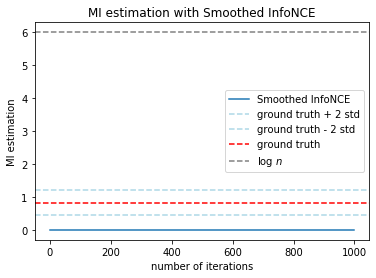

In [ ]:
std = 0.183

plt.plot(mi_copy, label='Smoothed InfoNCE')

plt.axhline(Ground_truth+2*std,label='ground truth + 2 std',linestyle='--',color='lightblue')
plt.axhline(Ground_truth-2*std,label='ground truth - 2 std',linestyle='--',color='lightblue')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('MI estimation with Smoothed InfoNCE')
plt.legend()
# plt.savefig(f'results/InfoNCE_wo_datapoints_dim{opt.d}_ma{ma_rate}.pdf')

In [ ]:
def plot_subfigure(net, X, Y, dimX, dimY, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=None, show_details=True):
    """
    The inputs should be X and Y, which are the coordinates of the points.

    net should be a neural network with Tensor inputs.
    """

    if  x0 == None:
        x0 = np.zeros((1, X.shape[1]))
    if y0 == None:
        y0 = np.zeros((1, Y.shape[1]))
        
    x, y = np.mgrid[xmin:xmax:xgrids * 1j, ymin:ymax:ygrids * 1j]
    with torch.no_grad():
        z = (net(
            torch.cat((torch.Tensor((np.arange(X.shape[-1]) == dimX).reshape(1, -1) *
                    x.reshape(-1, 1) + x0).to(DEVICE),
            torch.Tensor((np.arange(X.shape[-1]) == dimY).reshape(1, -1) *
                    y.reshape(-1, 1) + y0).to(DEVICE),
        ),dim=-1)).reshape(x.shape).cpu())
    if ax is None:
        ax = plt.gca()
    # im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto")
    im = ax.pcolormesh(x, y, z, cmap="RdBu_r", shading="auto")
    # ax.figure.colorbar(im)
    if show_details:
        ax.figure.colorbar(im) 
        ax.set(xlabel="$x^{{({0})}}-x_0^{{({0})}}$",
                ylabel="$x^{{({0})}}-x_0^{{({0})}}$",
                title=r"Heatmap of $t(x,y)$")
    return im

TypeError: 'AxesSubplot' object is not subscriptable

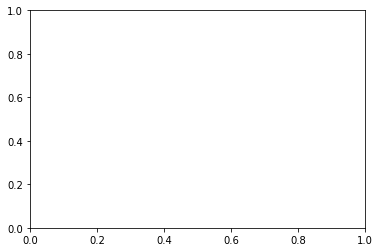

In [ ]:
d = 1
# DEVICE = "cuda"
f, axs = plt.subplots(nrows=d,ncols=d)
for i in range(d):
    for j in range(d):
        im = plot_subfigure(discriminator, X, Y, dimX=i, dimY=j, x0=None, y0=None, xmin=-5, xmax=5, ymin=-5, ymax=5, xgrids=50, ygrids=50, ax=axs[i, j], show_details=False)

f.colorbar(im, ax=axs.ravel().tolist())
# plt.savefig(f'results/InfoNCE_heatmap_dim{opt.d}.pdf')
plt.show()